## Continued Exploration of High Scoring Affairs
In soccer analytics there are many results considered.  Because coaching is also interested in patterns in the game, the hidden truths in the data, and a question was posed regarding high scoring games.  Is there a pattern which these games fall into, where defense is thrown out the window and goals come in high numbers.  Soccer/Football is for all intents and purposes a low scoring game. The introduction of the 3 point win was a huge shift in teams pursuing wins and not draws.  Even so, two to three goals is a pretty common outcome for a match.

What about the exceptions?  Not the one sided exceptions.  The track meets where the last team with the ball might be the winner.  The games where goals come fast and furious, but no team has a significant advantage.  Score lines like 4-3 or 5-5 come to mind.  Games with at least six goals which are well distributed.  Is there anything to learn from these *High Scoring Affairs*?

The first notebook analysis identified the data aggregation views.  This highlighted that more shots were taken, and they were taken closer to the goal.  Analysis of passing and recieve patterns for both HSA and non HSA games showed basically the same distibution of patterns, as did the turnover locations follow state likelywise.  Here, the goal will be to see how shots develop in live play through passing patterns.

---
### Imports and Data

In [1]:
import mplsoccer as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import pandas as pd
import numpy as np

from statsbombpy import sb
# suppress due to free data warning
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

### Competitions

In [2]:
# Break down on total seasons by competition name
(sb.competitions(creds={'user': None, 'passwd': None})
 .competition_name.value_counts()
 .rename('Seasons')
)

competition_name
Champions League           18
La Liga                    18
FIFA World Cup              8
Ligue 1                     3
Copa del Rey                3
FA Women's Super League     3
Liga Profesional            2
Serie A                     2
Premier League              2
1. Bundesliga               2
Women's World Cup           2
African Cup of Nations      1
Major League Soccer         1
North American League       1
NWSL                        1
Indian Super league         1
FIFA U20 World Cup          1
UEFA Euro                   1
UEFA Europa League          1
UEFA Women's Euro           1
Name: Seasons, dtype: int64

### Match Example

In [3]:
sb.matches(11,1).iloc[0] # characteristic record

match_id                                       9880
match_date                               2018-04-14
kick_off                               16:15:00.000
competition                         Spain - La Liga
season                                    2017/2018
home_team                                 Barcelona
away_team                                  Valencia
home_score                                        2
away_score                                        1
match_status                              available
match_status_360                          scheduled
last_updated             2023-02-08T17:23:53.901920
last_updated_360            2021-06-13T16:17:31.694
match_week                                       32
competition_stage                    Regular Season
stadium                            Spotify Camp Nou
referee                     Carlos del Cerro Grande
home_managers              Ernesto Valverde Tejedor
away_managers                Marcelino García Toral
data_version

### HSA Record Inspection
The match_id along with the home and away score can be inspected from the data which is available.  A column will need to be added for the total match goals and total differential, and finally a binary for HSA classification.  This can then be used to add match_ids to a dataframe/list for extraction of event data.

In [4]:
def hsa_add(df, goals=4, diff=3, HSA=1):
    '''Adds columns for total goals, total goal differential and HSA classifier.
    Returns dataframe where games are considered High Scoring Affairs or HSAs.
    df = dataframe from statsbomb
    goals = number in total to exceed in game
    diff = difference between score threshold'''
    df_update = (df
                 .assign(total_goals = lambda df: df.home_score + df.away_score,
                         goal_diff = lambda df: abs(df.home_score - df.away_score),
                         HSA = lambda df: np.where(df.total_goals>goals,np.where(df.goal_diff<diff,1,0),0))
                 ).query('HSA==@HSA')
    return df_update

In [5]:
# def non_hsa_add(df, goals=4, diff=3):
#     '''Adds columns for total goals, total goal differential and HSA classifier.
#     Returns dataframe where games are considered High Scoring Affairs or HSAs.
#     df = dataframe from statsbomb
#     goals = number in total to exceed in game
#     diff = difference between score threshold'''
#     df_update = (df
#                  .assign(total_goals = lambda df: df.home_score + df.away_score,
#                          goal_diff = lambda df: abs(df.home_score - df.away_score),
#                          HSA = lambda df: np.where(df.total_goals<goals,np.where(df.goal_diff<diff,1,0),0))
#                  ).query('HSA==0')
#     return df_update

### Extract Competitions and Seasons
Extract all competitions and seasons, then extract and append all of the HSA games into a single database so the match_ids can be pull and the event data can be evaluated. Here, both the HSA and Non_HSA classified matches can be extracted.  

In [6]:
def extract_comps(df):
    '''Extract a list of tuples for compeition and season ids.'''
    L = []
    for ind, row in (df.iterrows()):
        L.append((row.competition_id, row.season_id))
    return L

In [7]:
try:
    hsa_df = pd.read_csv('./data/hsa_df.csv')
    print('Read CSV from memory')
except:  # noqa: E722
    hsa_df = pd.DataFrame()
    for i in extract_comps(sb.competitions()):
        hsa_df= pd.concat([hsa_df,hsa_add(sb.matches(i[0],i[1]),5,3,1)])
    print('Used Statsbomb API')
    hsa_df.to_csv('./data/hsa_df.csv')
    

Used Statsbomb API


In [9]:
try:
    non_hsa_df = pd.read_csv('./data/non_hsa_df.csv')
    print('Read CSV from memory')
except:  # noqa: E722
    non_hsa_df = pd.DataFrame()
    for i in extract_comps(sb.competitions()):
        non_hsa_df= pd.concat([non_hsa_df,hsa_add(sb.matches(i[0],i[1]),5,3,0)])
    print('Used Statsbomb API')
    non_hsa_df.to_csv('./data/non_hsa_df.csv')
    

Used Statsbomb API


In [10]:
hsa_matches = hsa_df.reset_index().match_id.values

In [11]:
non_hsa_matches = non_hsa_df.reset_index().match_id.values

In [12]:
print(len(hsa_matches))
print(len(non_hsa_matches))

110
3240


### Total Available Matches
In total, there are 110 matches across the entire dataset of competitions in the Statsbomb free datasets.  Without having inspected the specifics, that feels about right.  It wouldn't do to have thousands of matches in this category.  More often, soccer is a low scoring game.  Achieving more than 5 goals with a difference of less than 3 is an uncommon result.

### Extracting Events
All events are extracted and aggregated across all 110 HSA and the 110 non HSA matches in this analysis. 

In [13]:
# defining universal event extractor function
def full_event_extract(match_ids):
    '''Returns all events using the statsbomb library and the match list previously defined.
    matchid = number or array of numbers containing matchid
    '''
    event_df = pd.DataFrame()
    for i in match_ids:
        event_df = pd.concat([sb.events(i),event_df])
    return event_df

In [37]:
try:
    hsa_events_df = pd.read_csv('./data/hsa_events_df.csv')
    print('read CSV')
except:  # noqa: E722
    hsa_events_df = (full_event_extract(hsa_matches)
                    .dropna(axis=1, how='all')
                    .assign(time = lambda df: pd.to_timedelta(df.timestamp))
                    )
    print('Used statsbomb API')
    hsa_events_df.to_csv('./data/hsa_events_df.csv')

read CSV


In [38]:
try:
    non_hsa_events_df = pd.read_csv('./data/non_hsa_events_df.csv')
    print('read CSV')
except:  # noqa: E722
    np.random.seed(42)
    non_hsa_events_df = (full_event_extract(np.random.choice(non_hsa_matches,size=110))
                    .dropna(axis=1, how='all')
                    .assign(time = lambda df: pd.to_timedelta(df.timestamp))
                    )
    print('Used statsbomb API')
    non_hsa_events_df.to_csv('./data/non_hsa_events_df.csv')

read CSV


### Possession Chains
Moving into more refined analysis, the possession chains which lead to goals will be evaluated to determine the difference between HSA games and Non HSA games.  Do the HSA games demonstrate longer chains? Is length based on the number of passes or the amount of time in possession before a shot occurs.  The focus for this analysis will be on chains which result in a shot or goal, since that is the primary focus of this analysis.

Using the turtorial from MPL soccer, the expected threat matrix will be recreated and used to evaluate possessions in both the HSA and Non HSA games.  The Statsbomb data comes with possession chains highlighted, so the designation of chains has been completed.  

Initially, some basic grouping and aggregation analysis will be done to evaluate any trends which are differentiated between the HSA and Non HSA possession data.  Afterward, xT will be evaluated to determine if there is more value created in HSA games versus Non HSA games.  

In [16]:
import datetime as dt

In [17]:
hsa_shot_poss_df = (hsa_events_df
 .loc[:,['index','possession','possession_team','type','location','shot_outcome','match_id',
         'minute','period','timestamp','duration','id','related_events','pass_length']]
 .query("type.isin(['Pass', 'Ball Receipt*', 'Carry','Ball Recovery', 'Pressure', 'Miscontrol', 'Clearance', 'Shot','Duel','Dispossessed','Dribbled Past', 'Dribble', 'Interception'])")
 .sort_values(by='index')
 .drop(['index','id','related_events'],axis=1)
 .dropna(subset='location',how='any')
 .assign(events = 1,
         location_s = lambda df: df.location.apply(lambda L: eval(str(L))),
         location_f = lambda df: df.location.apply(lambda L: eval(str(L))),
         timestamp = lambda df: pd.to_timedelta(df.timestamp))
 .groupby(by=['match_id','possession'], as_index=False).agg({'possession_team':'first','type':'last','events':'sum',
                                                             'location_s':'first','location_f':'last','pass_length':'sum',
                                                             'duration':'sum','shot_outcome':'last',
                                                             'minute':'last','period':'mean', 'timestamp':'last'})
 .query('~shot_outcome.isna()')
 .assign(time_min = lambda df: df.duration/60,
         eps = lambda df: df.events/df.duration,
         pdps = lambda df: df.pass_length/df.duration,
         goal = lambda df: np.where(df.shot_outcome=="Goal","Y","N"),
         x = lambda df: df.location_s.apply(lambda x: x[0]),
         y = lambda df: df.location_s.apply(lambda y: y[1]),
         end_x = lambda df: df.location_f.apply(lambda x: x[0]),
         end_y = lambda df: df.location_f.apply(lambda y: y[1]))
)

In [19]:
non_hsa_shot_poss_df = (non_hsa_events_df
 .loc[:,['index','possession','possession_team','type','location','shot_outcome','match_id',
         'minute','period','timestamp','duration','id','related_events','pass_length']]
 .query("type.isin(['Pass', 'Ball Receipt*', 'Carry','Ball Recovery', 'Pressure', 'Miscontrol', 'Clearance', 'Shot','Duel','Dispossessed','Dribbled Past', 'Dribble', 'Interception'])")
 .sort_values(by='index')
 .drop(['index','id','related_events'],axis=1)
 .dropna(subset='location',how='any')
 .assign(events = 1,
         location_s = lambda df: df.location.apply(lambda L: eval(str(L))),
         location_f = lambda df: df.location.apply(lambda L: eval(str(L))),
         timestamp = lambda df: pd.to_timedelta(df.timestamp))
 .groupby(by=['match_id','possession'], as_index=False).agg({'possession_team':'first','type':'last','events':'sum',
                                                             'location_s':'first','location_f':'last','pass_length':'sum',
                                                             'duration':'sum','shot_outcome':'last',
                                                             'minute':'last','period':'mean', 'timestamp':'last'})
 .query('~shot_outcome.isna()')
 .assign(time_min = lambda df: df.duration/60,
         eps = lambda df: df.events/df.duration,
         pdps = lambda df: df.pass_length/df.duration,
         goal = lambda df: np.where(df.shot_outcome=="Goal","Y","N"),
         x = lambda df: df.location_s.apply(lambda x: x[0]),
         y = lambda df: df.location_s.apply(lambda y: y[1]),
         end_x = lambda df: df.location_f.apply(lambda x: x[0]),
         end_y = lambda df: df.location_f.apply(lambda y: y[1]))
)

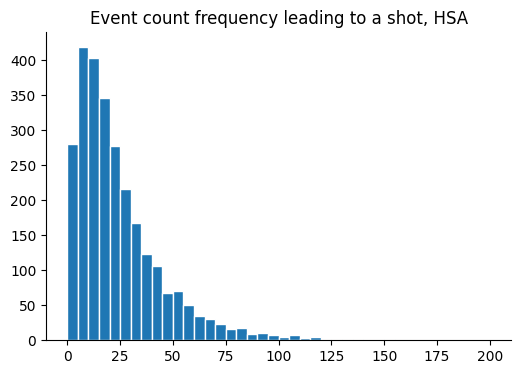

In [20]:
fig, ax = plt.subplots(figsize=(6,4))

data = (hsa_shot_poss_df
        .query('events>2')[['shot_outcome','events','duration']]
#         .groupby('shot_outcome', as_index=False).agg('median')
#         .sort_values('duration')
       )

ax.hist(x=data.events,bins=[i for i in range(0,201,5)], edgecolor='white')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)
ax.set_title('Event count frequency leading to a shot, HSA')
plt.show()

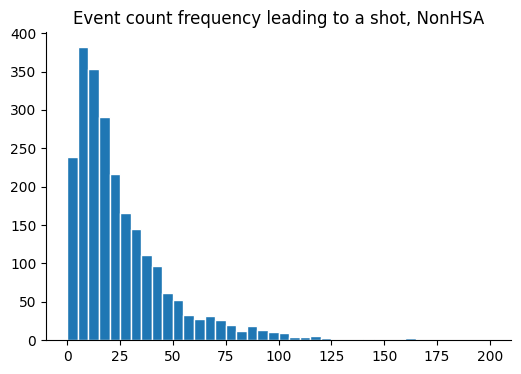

In [21]:
fig, ax = plt.subplots(figsize=(6,4))

data = (non_hsa_shot_poss_df
        .query('events>2')[['shot_outcome','events','duration']]
#         .groupby('shot_outcome', as_index=False).agg('median')
#         .sort_values('duration')
       )

ax.hist(x=data.events,bins=[i for i in range(0,201,5)], edgecolor='white')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)
ax.set_title('Event count frequency leading to a shot, NonHSA')
plt.show()

Text(0.5, 1.0, 'HSA shot outcome build up duration')

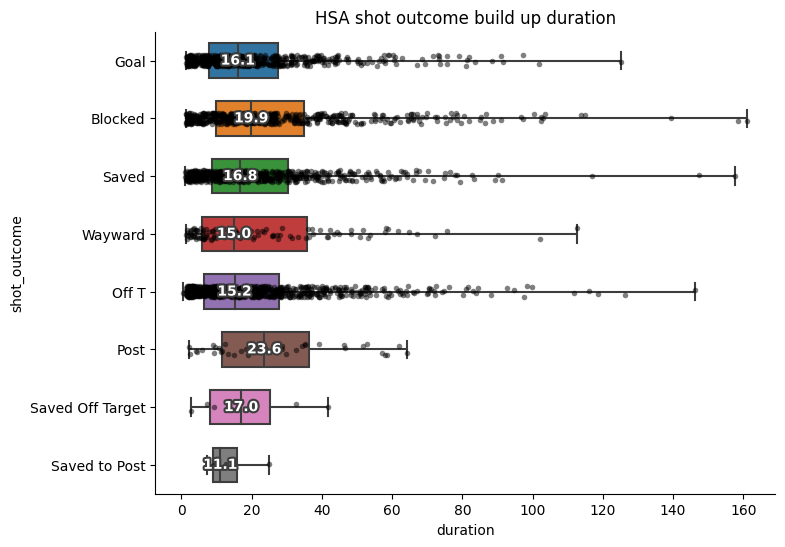

In [22]:
fig, ax = plt.subplots(figsize=(8,6))

data = hsa_shot_poss_df.query('events>2')

p1 = sns.boxplot(data=data, y='shot_outcome', x='duration', orient='h', whis=[0, 100], width=.6)

p2 = sns.stripplot(data, y="shot_outcome", x="duration", size=4, color="black", alpha=0.5)

def add_median_labels(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])
        
add_median_labels(p1)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)
ax.set_title('HSA shot outcome build up duration')

Text(0.5, 1.0, 'Non HSA shot build up duration')

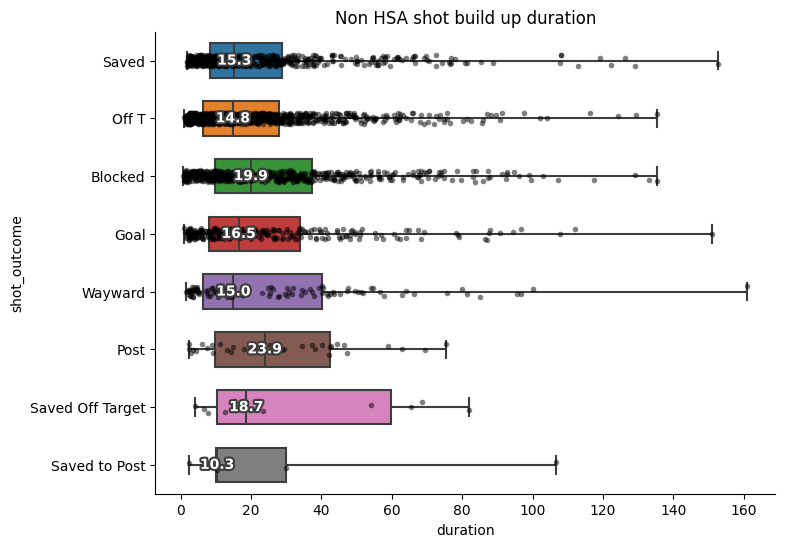

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

data = non_hsa_shot_poss_df.query('events>2')

p1 = sns.boxplot(data=data, y='shot_outcome', x='duration', orient='h', whis=[0, 100], width=.6)

p2 = sns.stripplot(data, y="shot_outcome", x="duration", size=4, color="black", alpha=0.5)
        
add_median_labels(p1)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)
ax.set_title('Non HSA shot build up duration')

In [24]:
print('HSA avg buid up duration:',hsa_shot_poss_df.duration.mean(),'avg touches:',hsa_shot_poss_df.events.mean())
print('Non HSA avg buid up duration:',non_hsa_shot_poss_df.duration.mean(),'avg touches:',non_hsa_shot_poss_df.events.mean())

HSA avg buid up duration: 20.707376679604526 avg touches: 22.32316655243317
Non HSA avg buid up duration: 22.33264207404721 avg touches: 23.87708587708588


In [25]:
print('HSA median buid up duration:',hsa_shot_poss_df.duration.median(),'med touches:',hsa_shot_poss_df.events.median())
print('Non HSA median buid up duration:',non_hsa_shot_poss_df.duration.median(),'med touches:',non_hsa_shot_poss_df.events.median())

HSA median buid up duration: 15.154926999999999 med touches: 16.0
Non HSA median buid up duration: 15.107594 med touches: 17.0


In [26]:
print('HSA median buid up eps:',hsa_shot_poss_df.eps.median(),'avg eps:',hsa_shot_poss_df.eps.mean())
print('Non HSA median buid up eps:',non_hsa_shot_poss_df.eps.median(),'avg eps:',non_hsa_shot_poss_df.eps.mean())

HSA median buid up eps: 1.1262660026965579 avg eps: 1.2608611862353363
Non HSA median buid up eps: 1.1148978616983696 avg eps: 1.23411847683458


In [27]:
import matplotlib.ticker as mticker

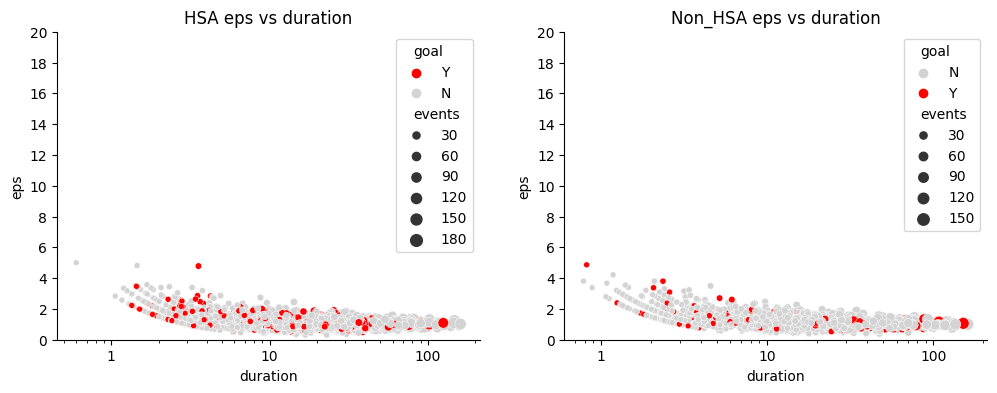

In [28]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
names = ['HSA','Non_HSA']
data1 = hsa_shot_poss_df.query('events>2 and eps<70')

p1 = sns.scatterplot(data=data1, y='eps',x='duration', hue='goal', size='events', 
                     ax=ax[0], palette={"Y":'r',"N":'lightgray'})

data2 = non_hsa_shot_poss_df.query('events>2 and eps<35')

p2 = sns.scatterplot(data=data2, y='eps',x='duration', hue='goal', size='events', 
                     ax=ax[1], palette={"Y":'r',"N":'lightgray'})

for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_yticks([i for i in range(0,21,2)])
    ax[i].xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_title(f'{names[i]} eps vs duration')

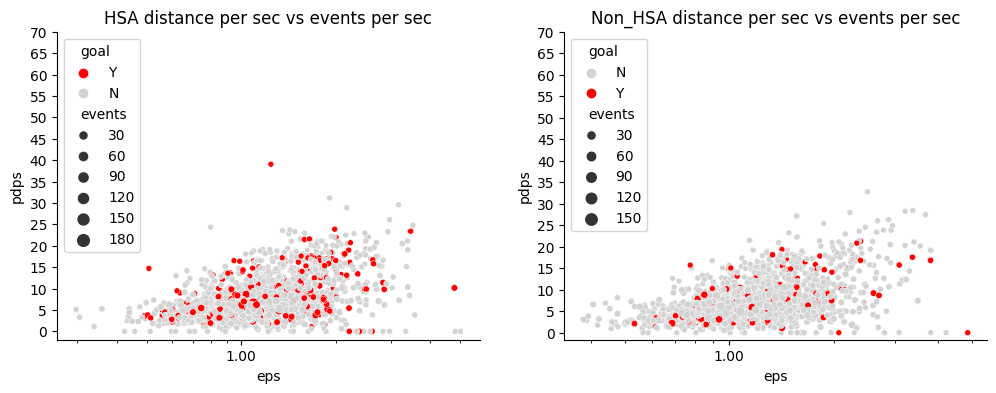

In [29]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
names = ['HSA','Non_HSA']
data1 = hsa_shot_poss_df.query('events>2')

p1 = sns.scatterplot(data=data1, y='pdps',x='eps', hue='goal', size='events', ax=ax[0], palette={"Y":'r',"N":'lightgray'})

data2 = non_hsa_shot_poss_df.query('events>2')

p2 = sns.scatterplot(data=data2, y='pdps',x='eps', hue='goal', size='events', ax=ax[1], palette={"Y":'r',"N":'lightgray'})

for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_yticks([i for i in range(0,75,5)])
    ax[i].xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_title(f'{names[i]} distance per sec vs events per sec')

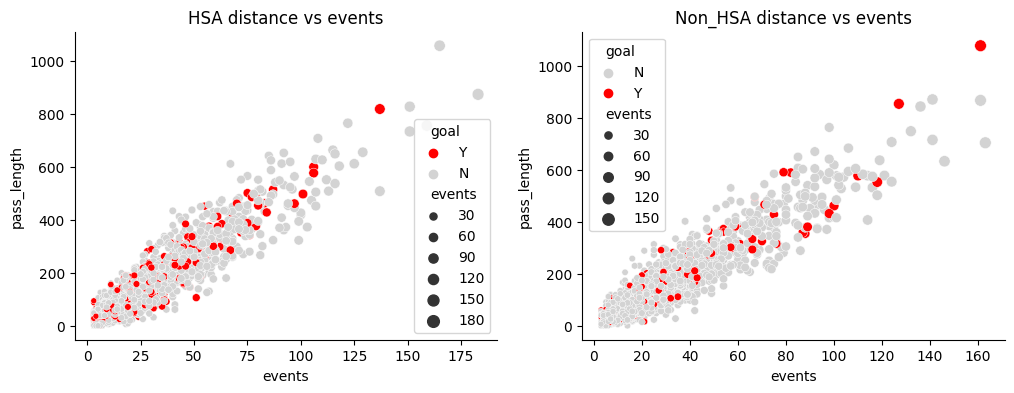

In [30]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
names = ['HSA','Non_HSA']
# data = pd.concat([hsa_shot_poss_df.query('events>2').assign(hsa = 1),
#                   non_hsa_shot_poss_df.query('events>2').assign(hsa=0)]
#                    )
data1 = hsa_shot_poss_df.query('events>2')

p1 = sns.scatterplot(data=data1, y='pass_length',x='events', hue='goal', size='events', 
                     ax=ax[0], palette={"Y":'r',"N":'lightgray'})

data2 = non_hsa_shot_poss_df.query('events>2')

p2 = sns.scatterplot(data=data2, y='pass_length',x='events', hue='goal', size='events', 
                     ax=ax[1], palette={"Y":'r',"N":'lightgray'})

for i in range(2):
    ax[i].set_xscale('linear')
#     ax[i].set_yticks([i for i in range(0,50,2)])
    ax[i].xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_title(f'{names[i]} distance vs events')

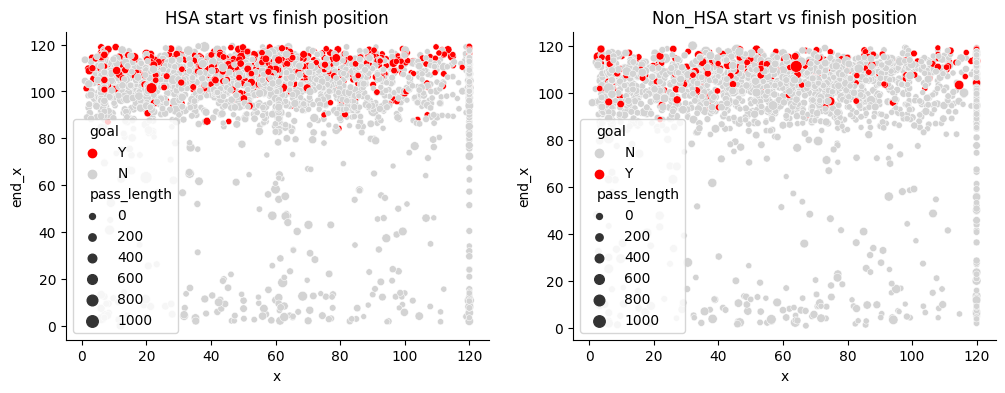

In [31]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
names = ['HSA','Non_HSA']
# data = pd.concat([hsa_shot_poss_df.query('events>2').assign(hsa = 1),
#                   non_hsa_shot_poss_df.query('events>2').assign(hsa=0)]
#                    )

data1 = hsa_shot_poss_df.query('events>2')

p1 = sns.scatterplot(data=data1, y='end_x',x='x', hue='goal', size='pass_length', 
                     ax=ax[0], palette={"Y":'r',"N":'lightgray'})

data2 = non_hsa_shot_poss_df.query('events>2')

p2 = sns.scatterplot(data=data2, y='end_x',x='x', hue='goal', size='pass_length', 
                     ax=ax[1], palette={"Y":'r',"N":'lightgray'})

for i in range(2):
    ax[i].set_xscale('linear')
#     ax[i].set_yticks([i for i in range(0,50,2)])
    ax[i].xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_title(f'{names[i]} start vs finish position')

Text(0.5, 1.0, 'Non HSA games')

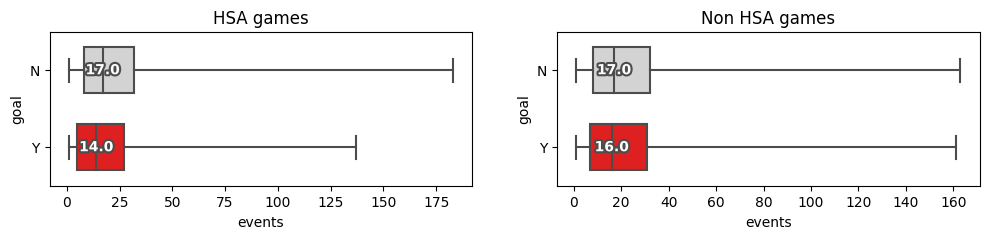

In [32]:
fig,ax=plt.subplots(ncols=2, figsize=(12,2))
data3=hsa_shot_poss_df.sort_values('goal')
p1=sns.boxplot(data3,x='events', y='goal', whis=[0, 100], width=.6, orient='h', 
               ax=ax[0], palette={"Y":'r',"N":'lightgray'})
data4=non_hsa_shot_poss_df.sort_values('goal')
p2=sns.boxplot(data4,x='events', y='goal', whis=[0, 100], width=.6, orient='h', 
               ax=ax[1], palette={"Y":'r',"N":'lightgray'})
add_median_labels(p1)
add_median_labels(p2)
ax[0].set_title('HSA games')
ax[1].set_title('Non HSA games')

Text(0.5, 1.0, 'Non HSA shooting position')

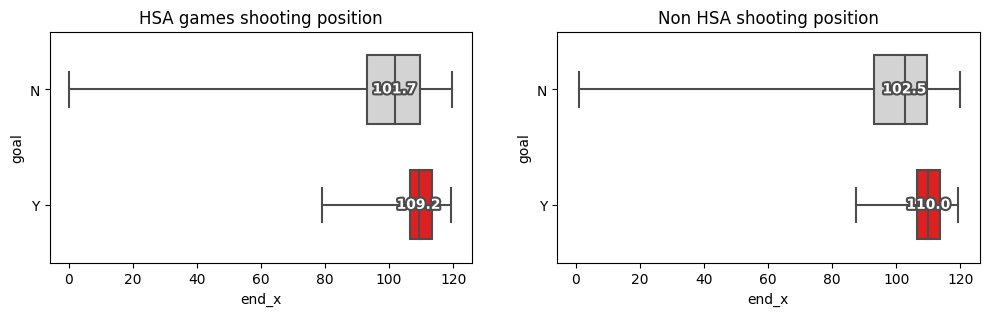

In [33]:
fig,ax=plt.subplots(ncols=2, figsize=(12,3), sharex=True)
data1=hsa_shot_poss_df.sort_values('goal')
p1=sns.boxplot(data1,x='end_x',y='goal', whis=[0, 100], width=.6, orient='h', ax=ax[0], palette={"Y":'r',"N":'lightgray'})
data2=non_hsa_shot_poss_df.sort_values('goal')
p2=sns.boxplot(data2,x='end_x',y='goal', whis=[0, 100], width=.6, orient='h', ax=ax[1], palette={"Y":'r',"N":'lightgray'})
add_median_labels(p1)
add_median_labels(p2)
ax[0].set_title('HSA games shooting position')
ax[1].set_title('Non HSA shooting position')

---
## Xt Model
Taken from MPLsoccer tutorial and reapplied to the games of interest for analysis.


### The Grid
Our first decision, is how to grid the soccer field. Here we copy the MPLsoccer setup and have 16 cells in the x-direction and 12 cells in the y-direction.

In [34]:
# Set up the grid
bins = (16,12)

Create a dataframe of the events using the column equivalents shown below: 
```cols = ['match_id', 'id', 'type_name', 'sub_type_name', 'player_name',
        'x', 'y', 'end_x', 'end_y', 'outcome_name', 'shot_statsbomb_xg']```

In [35]:
def check(x):
    if any(x.str.startswith('[')):
        return (x)

In [39]:
hsa_xT_event_df = (hsa_events_df
 .loc[:,['match_id','id','type','player','location','shot_end_location','pass_end_location',
         'carry_end_location','shot_outcome','pass_outcome','dribble_outcome','shot_statsbomb_xg']]
 .query('type.isin(["Carry","Shot","Pass"])')
 .fillna('')
 .assign(goal = lambda df: np.where(df.shot_outcome=="Goal",1,0),
         shoot = lambda df: np.where(df.type == "Shot",1,0),
         move = lambda df: np.where(df.type != "Shot",1,0),
         outcome_name = lambda df: df.pass_outcome + df.shot_outcome,
         x = lambda df: df.location.apply(lambda x:eval(x)[0]),
         y = lambda df: df.location.apply(lambda y:eval(y)[1]),
         ends = lambda df: df['pass_end_location']+df['shot_end_location']+df['carry_end_location'],
         end_x = lambda df: df.ends.apply(lambda x:eval(x)[0]),
         end_y = lambda df: df.ends.apply(lambda y:eval(y)[1])
        )
)

### Bin the data
Calculate the probability of a shot, successful move (pass or carry), and goal (given a shot). Averaging the boolean columns (True = 1) and (False = 0) to give us the probability between zero and one.

In [40]:
pitch = mpl.Pitch(line_zorder=2)

In [41]:
event=hsa_xT_event_df
shot_probability = pitch.bin_statistic(event['x'], event['y'], values=event['shoot'],
                                       statistic='mean', bins=bins)
move_probability = pitch.bin_statistic(event['x'], event['y'], values=event['move'],
                                       statistic='mean', bins=bins)
goal_probability = pitch.bin_statistic(event.loc[lambda df: df.shoot==1, 'x'],
                                       event.loc[lambda df: df.shoot==1, 'y'],
                                       event.loc[lambda df: df.shoot==1, 'goal'],
                                       statistic='mean', bins=bins)

### Plot shot and move probability
Move probabilities are the mirror of the shot probability. The shot_probability + goal_probability adds up to one for each grid cell, as we assume only these two event types occur when in possession.

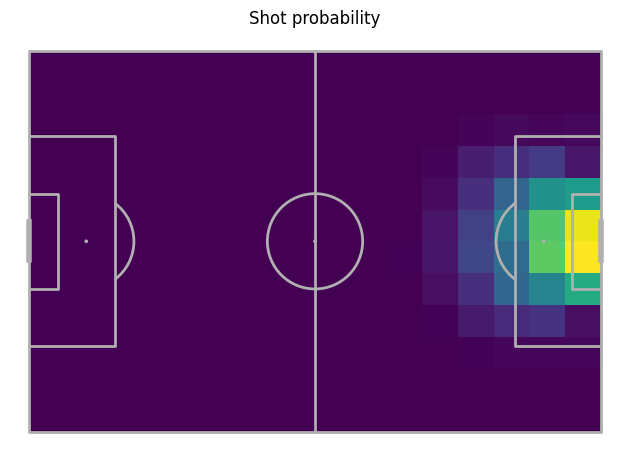

In [42]:
fig, ax = pitch.draw()
shot_heatmap = pitch.heatmap(shot_probability, ax=ax)
ax.set_title('Shot probability');

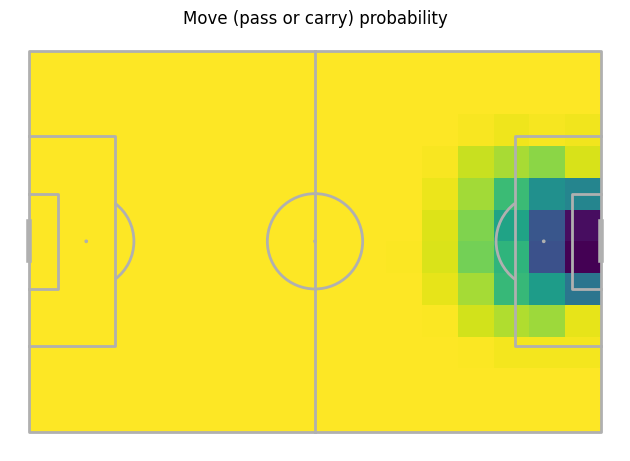

In [43]:
fig, ax = pitch.draw()
move_heatmap = pitch.heatmap(move_probability, ax=ax)
ax.set_title('Move (pass or carry) probability');

### Plot goal probability
This is the likelihood of scoring from a shot, versus the likelihood of shooting.  Earlier, the views were not based on scoring chance, but the attractiveness of a possition for shooting.  

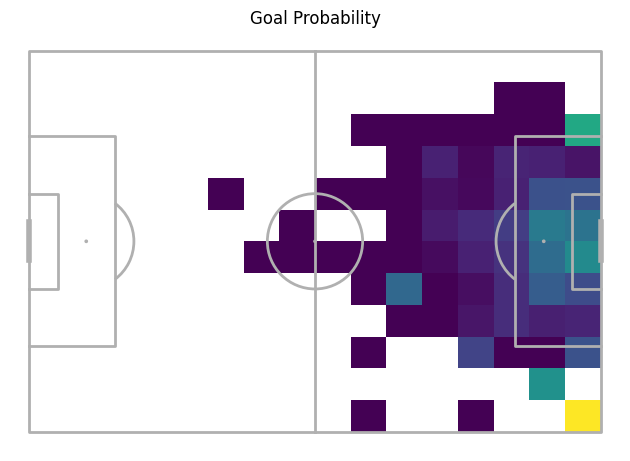

In [44]:
fig, ax = pitch.draw()
goal_heatmap = pitch.heatmap(goal_probability, ax=ax)
ax.set_title('Goal Probability');

### Position Network
Using the position tag, the average position on the pitch for each team will be leveraged to determine the overall average shape of the team on the field.  This will be mixing numerous tactics and concepts, and in all likelihood will wash out the information needed.  That said, this is the first attempt at understanding where players are on the pitch in the comparison datasets.

In [45]:
hsa_events_df.position.unique() # 27 unique position titles

array([nan, 'Center Forward', 'Center Attacking Midfield',
       'Right Center Midfield', 'Right Center Back',
       'Left Center Midfield', 'Right Back', 'Left Center Back',
       'Right Midfield', 'Left Back', 'Left Defensive Midfield',
       'Left Wing', 'Goalkeeper', 'Left Midfield',
       'Right Defensive Midfield', 'Right Wing', 'Center Back',
       'Left Wing Back', 'Right Center Forward', 'Left Center Forward',
       'Right Wing Back', 'Center Defensive Midfield',
       'Left Attacking Midfield', 'Right Attacking Midfield',
       'Center Midfield', 'Secondary Striker', 'Substitute'], dtype=object)

In [46]:
hsa_events_df.position.value_counts()

position
Left Center Back             32027
Right Back                   31397
Right Center Back            30958
Left Back                    30631
Right Center Midfield        23284
Left Center Midfield         23001
Center Forward               21560
Right Wing                   20742
Left Defensive Midfield      20062
Left Wing                    20045
Right Defensive Midfield     19021
Center Defensive Midfield    17987
Goalkeeper                   17813
Center Attacking Midfield    14742
Right Center Forward         12427
Left Center Forward          12339
Right Midfield               10695
Left Midfield                10645
Left Wing Back                4209
Right Wing Back               4153
Center Back                   3999
Left Attacking Midfield       1056
Right Attacking Midfield       971
Secondary Striker              573
Center Midfield                409
Substitute                       3
Name: count, dtype: int64

In [47]:
pos_eve_locs = (hsa_events_df
 .query('position!="Substitute" and type.isin(["Carry","Shot","Pass", "Dribble"])')
 .assign(pos = lambda df: df.position.apply(lambda x:''.join([word[0] for word in x.split()])),
         events = 1,
         x = lambda df: df.location.apply(lambda x: eval(x)[0]),
         y = lambda df: df.location.apply(lambda x: eval(x)[1]))
 .groupby(by='pos', as_index=False).agg({'x':'median','y':'median','events':'sum'})
)

In [48]:
MAX_MARKER_SIZE = 2500
pos_eve_locs['marker_size'] = (pos_eve_locs.events/pos_eve_locs.events.max()*MAX_MARKER_SIZE)

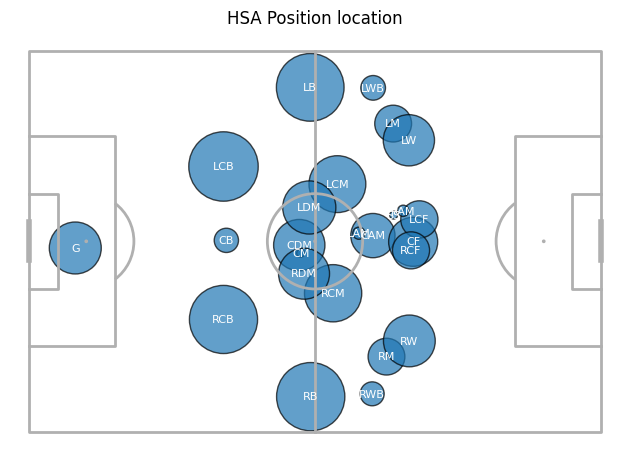

In [49]:
fig, ax = pitch.draw()
positions = pitch.scatter(pos_eve_locs.x, pos_eve_locs.y, ax=ax, s=pos_eve_locs.marker_size,
                         edgecolors='black', linewidth=1, alpha=0.7)
for index, row in pos_eve_locs.iterrows():
    pitch.annotate(row.pos, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=8, weight='normal', ax=ax, zorder=3)

ax.set_title('HSA Position location');

In [50]:
pos_eve_locs_non = (non_hsa_events_df
 .query('position!="Substitute" and type.isin(["Carry","Shot","Pass","Dribble"])')
 .assign(pos = lambda df: df.position.apply(lambda x:''.join([word[0] for word in x.split()])),
         events = 1,
         x = lambda df: df.location.apply(lambda x: eval(x)[0]),
         y = lambda df: df.location.apply(lambda x: eval(x)[1]))
 .groupby(by='pos', as_index=False).agg({'x':'median','y':'median','events':'sum'})
)

In [51]:
MAX_MARKER_SIZE = 2500
pos_eve_locs_non['marker_size'] = (pos_eve_locs_non.events/pos_eve_locs_non.events.max()*MAX_MARKER_SIZE)

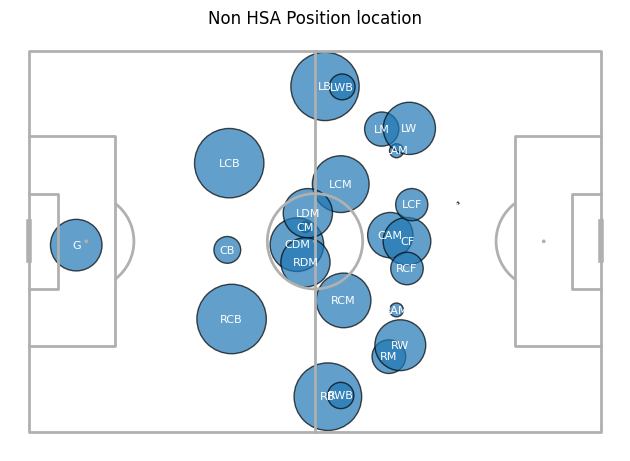

In [52]:
fig, ax = pitch.draw()
positions = pitch.scatter(pos_eve_locs_non.x, pos_eve_locs_non.y, ax=ax, s=pos_eve_locs_non.marker_size,
                         edgecolors='black', linewidth=1, alpha=0.7)
for index, row in pos_eve_locs_non.iterrows():
    pitch.annotate(row.pos, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=8, weight='normal', ax=ax, zorder=3)

ax.set_title('Non HSA Position location');

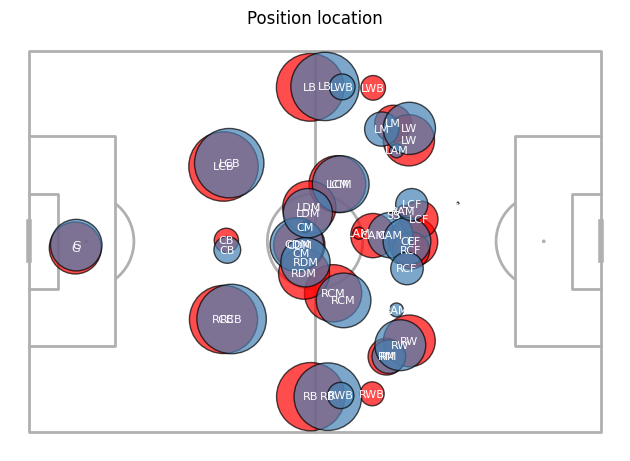

In [53]:
fig, ax = pitch.draw()
positions = pitch.scatter(pos_eve_locs.x, pos_eve_locs.y, ax=ax, s=pos_eve_locs.marker_size,
                         edgecolors='black', linewidth=1, alpha=0.7, color='red', zorder=2)
positions = pitch.scatter(pos_eve_locs_non.x, pos_eve_locs_non.y, ax=ax, s=pos_eve_locs_non.marker_size,
                         edgecolors='black', linewidth=1, alpha=0.7, color='steelblue', zorder=2)
for index, row in pos_eve_locs.iterrows():
    pitch.annotate(row.pos, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=8, weight='normal', ax=ax, zorder=3)
for index, row in pos_eve_locs_non.iterrows():
    pitch.annotate(row.pos, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=8, weight='normal', ax=ax, zorder=4)

ax.set_title('Position location');

### Position by type of play
Further refining the analysis, the data will be split out by the type of play/event to determine if there is any difference between the HSA and Non HSA games.  

In [54]:
hsa_events_df.type.unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Ball Recovery', 'Pressure', 'Miscontrol', 'Clearance', 'Shot',
       'Goal Keeper', 'Duel', 'Dispossessed', 'Injury Stoppage',
       'Dribbled Past', 'Dribble', 'Interception', 'Block',
       'Foul Committed', 'Foul Won', 'Player Off', 'Player On',
       'Half End', 'Substitution', 'Own Goal Against', 'Own Goal For',
       'Bad Behaviour', 'Shield', 'Tactical Shift', 'Referee Ball-Drop',
       'Offside', '50/50', 'Error', 'Camera On', 'Camera off'],
      dtype=object)

In [55]:
types = ["Carry","Shot","Pass", "Dribble", 'Pressure', 'Dribbled Past']

In [56]:
hsa_pos_eve_type_locs = (hsa_events_df
 .query('position!="Substitute" and type.isin(@types)')
 .assign(pos = lambda df: df.position.apply(lambda x:''.join([word[0] for word in x.split()])),
         events = 1,
         x = lambda df: df.location.apply(lambda x: eval(x)[0]),
         y = lambda df: df.location.apply(lambda x: eval(x)[1]))
 .groupby(by=['pos','type'], as_index=False).agg({'x':'mean','y':'mean','events':'sum'})
)

In [57]:
MAX_MARKER_SIZE = 1000
hsa_pos_eve_type_locs['marker_size'] = (hsa_pos_eve_type_locs.events/hsa_pos_eve_type_locs.events.max()*MAX_MARKER_SIZE)

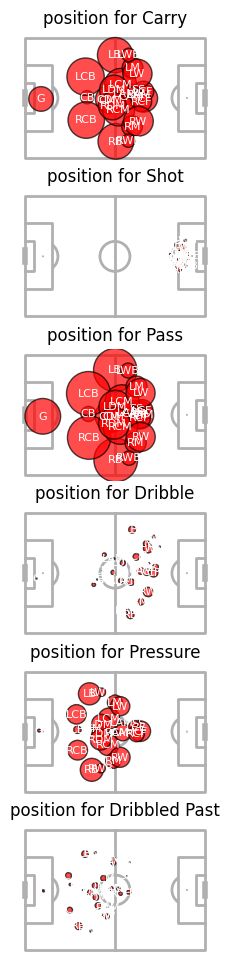

In [58]:
fig, axs = pitch.draw(nrows=len(types), tight_layout=False, constrained_layout=True, figsize=(6,12))
for i in range(len(types)):
    data = hsa_pos_eve_type_locs.query('type==@types[@i]')
    positions = pitch.scatter(data.x, data.y, s=data.marker_size, edgecolors='black', 
                              linewidth=1, alpha=0.7, color='red', zorder=2, ax=axs[i])
    for index, row in data.iterrows():
        pitch.annotate(row.pos, xy=(row.x, row.y), c='white', va='center',ha='center', 
                       size=8, weight='normal', ax=axs[i], zorder=3)
    axs[i].set_title(f'position for {types[i]}')

In [59]:
non_hsa_pos_eve_type_locs = (non_hsa_events_df
 .query('position!="Substitute" and type.isin(@types)')
 .assign(pos = lambda df: df.position.apply(lambda x:''.join([word[0] for word in x.split()])),
         events = 1,
         x = lambda df: df.location.apply(lambda x: eval(x)[0]),
         y = lambda df: df.location.apply(lambda x: eval(x)[1]))
 .groupby(by=['pos','type'], as_index=False).agg({'x':'mean','y':'mean','events':'sum'})
)

In [60]:
MAX_MARKER_SIZE = 1000
non_hsa_pos_eve_type_locs['marker_size'] = (non_hsa_pos_eve_type_locs.events/non_hsa_pos_eve_type_locs.events.max()*MAX_MARKER_SIZE)

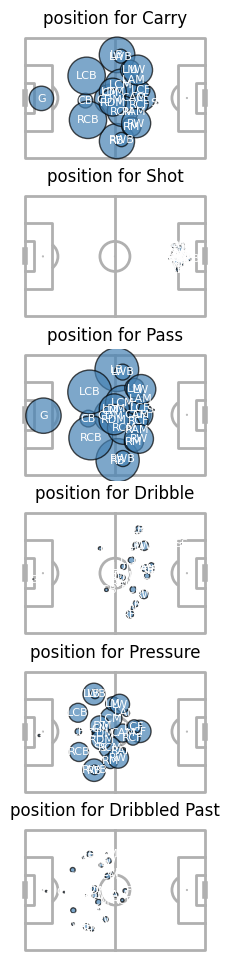

In [61]:
fig, axs = pitch.draw(nrows=len(types), tight_layout=False, constrained_layout=True, figsize=(6,12))
for i in range(len(types)):
    data = non_hsa_pos_eve_type_locs.query('type==@types[@i]')
    positions = pitch.scatter(data.x, data.y, s=data.marker_size, edgecolors='black', 
                              linewidth=1, alpha=0.7, color='steelblue', zorder=2, ax=axs[i])
    for index, row in data.iterrows():
        pitch.annotate(row.pos, xy=(row.x, row.y), c='white', va='center',ha='center', 
                       size=8, weight='normal', ax=axs[i], zorder=3)
    axs[i].set_title(f'position for {types[i]}')

### Further evaluation
When analyzing the data, there is very little difference beween the HSA and Non HSA data in combined positioning data.  In fact, the only obvious difference inbetween the two views is the dribble and shot positioning, which does show a difference in the distance up the field.  

An attempt will be made to look at the data in a given match, compairing the difference between the two teams which may speak to the space available on the field.  This could potentially leverage varoni diagrams for pitch control, but for the initial evaluation the goal will be to use simple positioning and event data.

In [62]:
types = ["Carry","Shot","Pass", "Dribble", 'Pressure', 'Dribbled Past']

In [73]:
hsa_match_pos_eve_type_locs = (hsa_events_df
 .query('position!="Substitute" and type.isin(@types)')
 .assign(pos = lambda df: df.position.apply(lambda x:''.join([word[0] for word in x.split()])),
         events = 1,
         x = lambda df: df.location.apply(lambda x: eval(x)[0]),
         y = lambda df: df.location.apply(lambda x: eval(x)[1]))
 .groupby(by=['match_id', 'team','pos'], as_index=False).agg({'x':'mean','y':'mean','events':'sum'})
)

In [74]:
non_hsa_match_pos_eve_type_locs = (non_hsa_events_df
 .query('position!="Substitute" and type.isin(@types)')
 .assign(pos = lambda df: df.position.apply(lambda x:''.join([word[0] for word in x.split()])),
         events = 1,
         x = lambda df: df.location.apply(lambda x: eval(x)[0]),
         y = lambda df: df.location.apply(lambda x: eval(x)[1]))
 .groupby(by=['match_id', 'team','pos'], as_index=False).agg({'x':'mean','y':'mean','events':'sum'})
)

In [77]:
MAX_MARKER_SIZE = 1000
hsa_match_pos_eve_type_locs['marker_size'] = (hsa_match_pos_eve_type_locs.events/hsa_match_pos_eve_type_locs.events.max()*MAX_MARKER_SIZE)
non_hsa_match_pos_eve_type_locs['marker_size'] = (non_hsa_match_pos_eve_type_locs.events/non_hsa_match_pos_eve_type_locs.events.max()*MAX_MARKER_SIZE)

In [84]:
hsa_match_pos_eve_type_locs.match_id.unique()

array([   7430,    7457,    7576,    7580,    8658,    9754,    9912,
         16029,   16056,   16190,   16240,   19724,   19734,   19781,
         19801,   68335,   68338,   68365,   69185,   69186,   69217,
         69227,   69250,   69327,   70225,   70281,   70304,  265857,
        266440,  266724,  267432, 2275105, 2275122, 2275133, 2302764,
       3749448, 3754056, 3754071, 3754088, 3754125, 3754131, 3754157,
       3754207, 3754237, 3754241, 3754282, 3754305, 3754320, 3754348,
       3773387, 3775561, 3788764, 3794686, 3794691, 3802643, 3813267,
       3813273, 3813283, 3813284, 3813287, 3813297, 3813314, 3813317,
       3813318, 3817870, 3825585, 3825632, 3825732, 3825770, 3825790,
       3825804, 3825816, 3825908, 3829427, 3829488, 3837771, 3837876,
       3837896, 3857259, 3857292, 3869685, 3879564, 3879590, 3879665,
       3879672, 3879687, 3879699, 3879730, 3879823, 3879851, 3879874,
       3889218, 3890292, 3890308, 3890335, 3890346, 3890354, 3890377,
       3890425, 3890

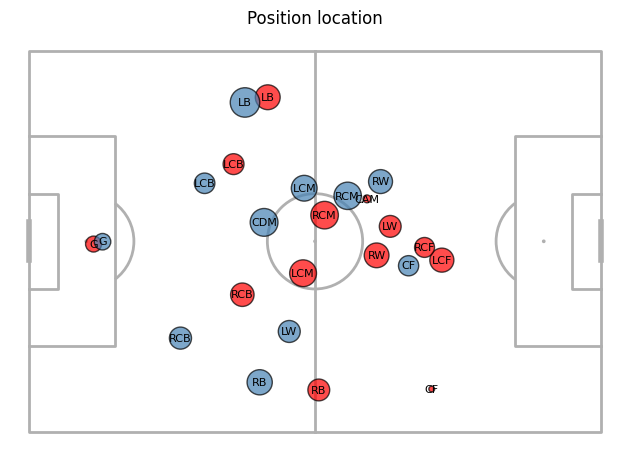

In [82]:
fig, ax = pitch.draw()
data1 = hsa_match_pos_eve_type_locs.query('match_id==7430 and team=="North Carolina Courage"')
data2 = hsa_match_pos_eve_type_locs.query('match_id==7430 and team!="North Carolina Courage"')

positions = pitch.scatter(data1.x, data1.y, ax=ax, s=data1.marker_size,
                         edgecolors='black', linewidth=1, alpha=0.7, color='red', zorder=2)
positions = pitch.scatter(data2.x, data2.y, ax=ax, s=data2.marker_size,
                         edgecolors='black', linewidth=1, alpha=0.7, color='steelblue', zorder=2)
for index, row in data1.iterrows():
    pitch.annotate(row.pos, xy=(row.x, row.y), c='black', va='center',
                   ha='center', size=8, weight='normal', ax=ax, zorder=3)
for index, row in data2.iterrows():
    pitch.annotate(row.pos, xy=(row.x, row.y), c='black', va='center',
                   ha='center', size=8, weight='normal', ax=ax, zorder=4)

ax.set_title('Position location');

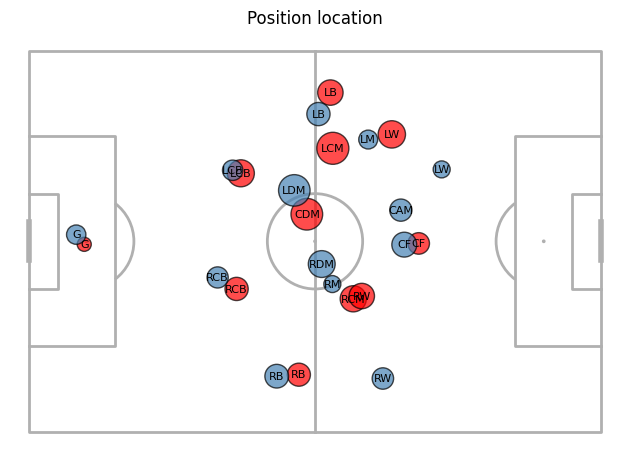

In [88]:
fig, ax = pitch.draw()
match = 3879699
data = hsa_match_pos_eve_type_locs
teams = data.query('match_id==@match').team.unique()
data1 = data.query('match_id==@match and team==@teams[0]')
data2 = data.query('match_id==@match and team==@teams[1]')

positions = pitch.scatter(data1.x, data1.y, ax=ax, s=data1.marker_size,
                         edgecolors='black', linewidth=1, alpha=0.7, color='red', zorder=2)
positions = pitch.scatter(data2.x, data2.y, ax=ax, s=data2.marker_size,
                         edgecolors='black', linewidth=1, alpha=0.7, color='steelblue', zorder=2)
for index, row in data1.iterrows():
    pitch.annotate(row.pos, xy=(row.x, row.y), c='black', va='center',
                   ha='center', size=8, weight='normal', ax=ax, zorder=3)
for index, row in data2.iterrows():
    pitch.annotate(row.pos, xy=(row.x, row.y), c='black', va='center',
                   ha='center', size=8, weight='normal', ax=ax, zorder=4)

ax.set_title('Position location');